<a href="https://colab.research.google.com/github/gdelaossat/classificationmodels/blob/main/MisionTIC2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from collections import Counter
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import NearMiss

# Funciones

In [ ]:
def show_results(output_val, predicted):
  cf_matrix = confusion_matrix(output_val, predicted)
  group_names = ['True Neg','False Pos','False Neg','True Pos']

  group_counts = ["{0:0.0f}".format(value) for value in
                  cf_matrix.flatten()]

  group_percentages = ["{0:.2%}".format(value) for value in
                      cf_matrix.flatten()/np.sum(cf_matrix)]

  labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]

  labels = np.asarray(labels).reshape(2,2)

  ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

  ax.set_title('Graduados \n\n');
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values ');

  ## Ticket labels - List must be in alphabetical order
  ax.xaxis.set_ticklabels(['False','True'])
  ax.yaxis.set_ticklabels(['False','True'])

  ## Display the visualization of the Confusion Matrix.
  plt.show()

  y_pred_proba = log_fit.predict_proba(input_val)[::,1]

  fper, tper, thresholds = metrics.roc_curve(output_val, y_pred_proba)



  plt.plot(fper, tper, color='red', label='ROC')
  plt.plot([0, 1], [0, 1], color='green', linestyle='--')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic Curve')
  plt.legend()
  plt.show()

  print (classification_report(output_val, predicted))

# Lectura de datos

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dfOriginal = pd.read_csv('/content/drive/MyDrive/Maestría GOB TI/Business Intelligence/misiontic2020.csv')


# Exploración de datos y limpieza

In [ ]:
dfOriginal.head(2)

,FECHA_CORTE,DEPARTAME_NOMBRE,MUNICIPIO_NOMBRE,ESTADO_FORMACION,ESTADOS,CONVOCATORIA,ESTRATO_SOCIAL,EDAD,GENERO,RUTA,GRADO,META_BENEFICIARIO,INVERSION,META_DINERO,FECHA_VIGENCIA
0,2021-10-01,QUINDIO,ARMENIA,ASPIRANTE,ASPIRANTES,1,3,29,MASCULINO,RUTA 2,-1,NaN,NaN,NaN,2021-12-31
1,2021-10-01,QUINDIO,ARMENIA,ASPIRANTE,ASPIRANTES,1,3,29,MASCULINO,RUTA 2,-1,NaN,NaN,NaN,2021-12-31


In [ ]:
dfOriginal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 429699 entries, 0 to 429698
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   FECHA_CORTE        429699 non-null  object 
 1   DEPARTAME_NOMBRE   429699 non-null  object 
 2   MUNICIPIO_NOMBRE   429699 non-null  object 
 3   ESTADO_FORMACION   429699 non-null  object 
 4   ESTADOS            429699 non-null  object 
 5   CONVOCATORIA       429699 non-null  int64  
 6   ESTRATO_SOCIAL     429699 non-null  object 
 7   EDAD               429699 non-null  int64  
 8   GENERO             429699 non-null  object 
 9   RUTA               429699 non-null  object 
 10  GRADO              429699 non-null  int64  
 11  META_BENEFICIARIO  0 non-null       float64
 12  INVERSION          0 non-null       float64
 13  META_DINERO        0 non-null       float64
 14  FECHA_VIGENCIA     429699 non-null  object 
dtypes: float64(3), int64(3), object(9)
memory usage: 49

Filtrando sólo matriculados

In [ ]:
df = dfOriginal[ (dfOriginal['ESTADO_FORMACION']=='MATRICULADO') | (dfOriginal['ESTADO_FORMACION']=='GRADUADO') ]

In [ ]:
df = df[['DEPARTAME_NOMBRE',
         'ESTRATO_SOCIAL', 'EDAD', 'GENERO', 'RUTA', 'GRADO','ESTADOS']]


In [ ]:
df['ESTUDIANTES'] = 1

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62710 entries, 80 to 429697
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   DEPARTAME_NOMBRE  62710 non-null  object
 1   ESTRATO_SOCIAL    62710 non-null  object
 2   EDAD              62710 non-null  int64 
 3   GENERO            62710 non-null  object
 4   RUTA              62710 non-null  object
 5   GRADO             62710 non-null  int64 
 6   ESTADOS           62710 non-null  object
 7   ESTUDIANTES       62710 non-null  int64 
dtypes: int64(3), object(5)
memory usage: 4.3+ MB


In [ ]:
select = ['ESTADOS','ESTUDIANTES']
grupos = ['ESTADOS']
df_result = df[select].groupby(by=grupos).count()
df_result.reset_index(inplace=True)
df_result.sort_values(ascending=False, by=['ESTUDIANTES'], inplace=True)
df_result

,ESTADOS,ESTUDIANTES
0,BENEFICIARIO,60034
1,GRADUADO,2676


Reemplazando el texto Beneficiario por no graduado

In [ ]:
df['ESTADOS'] = df['ESTADOS'].replace(['BENEFICIARIO'],'NO GRADUADO')
df['GRADUADO'] =  (df["ESTADOS"].replace({'GRADUADO': 1, 'NO GRADUADO': 0}))



Revisando la columna departamento

In [ ]:
df['DEPARTAME_NOMBRE'].unique()

array(['CORDOBA', 'BOYACA', 'CALDAS', 'SANTANDER', 'VALLE DEL CAUCA',
       'NORTE DE SANTANDER', 'TOLIMA', 'BOGOTA', 'CUNDINAMARCA',
       'GUAVIARE', 'HUILA', 'RISARALDA', 'MAGDALENA', 'ATLANTICO',
       'BOLIVAR', 'QUINDIO', 'CAUCA', 'ANTIOQUIA', 'NARIÑO', 'CESAR',
       'CASANARE', 'PUTUMAYO', 'CAQUETA', 'META', 'CHOCO', 'LA GUAJIRA',
       'SUCRE', 'GUAINIA', 'PENDIENTE CLASIFICAR', 'ARAUCA', 'VICHADA',
       'AMAZONAS', 'SAN ANDRES Y PROVIDENCIA', 'VAUPES'], dtype=object)

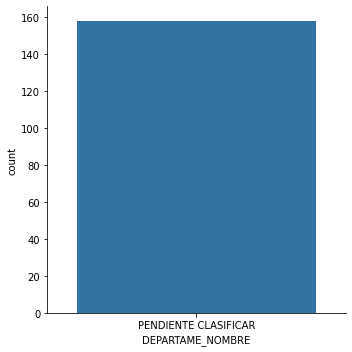

In [ ]:
df_result = df[ (df['DEPARTAME_NOMBRE']=='PENDIENTE CLASIFICAR')  ]

sns.catplot(x='DEPARTAME_NOMBRE', data=df_result, kind='count');
 


Quitando registros con el departamento sin clasificar

In [ ]:
df = df[ (df['DEPARTAME_NOMBRE']!='PENDIENTE CLASIFICAR')  ]

Revisando la columna estrato social

In [ ]:

select = ['ESTRATO_SOCIAL','ESTUDIANTES']
grupos = ['ESTRATO_SOCIAL']
df_result = df[select].groupby(by=grupos).count()
df_result.reset_index(inplace=True)
df_result.sort_values(ascending=False, by=['ESTUDIANTES'], inplace=True)
df_result



,ESTRATO_SOCIAL,ESTUDIANTES
1,2,23829
2,3,21069
0,1,11643
3,4,4638
4,5,959
5,6,245
6,a,169


Se quitarán registros con estrato social 'a'

In [ ]:
df = df[ (df['ESTRATO_SOCIAL']!='a')  ]

Analizando la columna EDAD

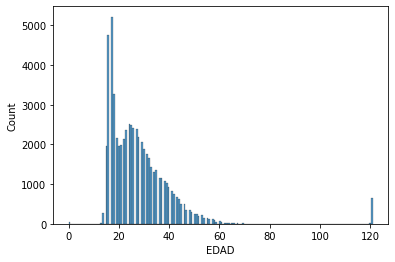

In [ ]:
sns.histplot(data=df, x="EDAD")

In [ ]:

select = ['EDAD','ESTUDIANTES']
grupos = ['EDAD']
df_result = df[select].groupby(by=grupos).count()
df_result.reset_index(inplace=True)
df_result.sort_values(ascending=False, by=['EDAD'], inplace=True)
df_result

,EDAD,ESTUDIANTES
70,121,648
69,120,19
68,104,1
67,97,2
66,78,1
...,...,...
4,13,24
3,8,1
2,5,1
1,4,1


Se removerán registros con edades atípicas, es decir < 13 y > 100

In [ ]:
df = df[ (df['EDAD']>=13) & (df['EDAD']<=100 )  ]


In [ ]:
df.head(100)

,DEPARTAME_NOMBRE,ESTRATO_SOCIAL,EDAD,GENERO,RUTA,GRADO,ESTADOS,ESTUDIANTES,GRADUADO
80,CORDOBA,1,22,FEMENINO,RUTA 2,-1,NO GRADUADO,1,0
123,BOYACA,2,22,FEMENINO,RUTA 2,-1,GRADUADO,1,1
148,BOYACA,2,15,FEMENINO,RUTA 1,10,GRADUADO,1,1
149,CALDAS,2,16,FEMENINO,RUTA 1,10,NO GRADUADO,1,0
186,SANTANDER,4,41,MASCULINO,RUTA 2,-1,NO GRADUADO,1,0
...,...,...,...,...,...,...,...,...,...
740,CASANARE,2,24,MASCULINO,RUTA 2,-1,NO GRADUADO,1,0
741,CASANARE,2,24,MASCULINO,RUTA 2,-1,NO GRADUADO,1,0
742,CASANARE,2,24,MASCULINO,RUTA 2,-1,NO GRADUADO,1,0
743,CASANARE,2,24,MASCULINO,RUTA 2,-1,NO GRADUADO,1,0


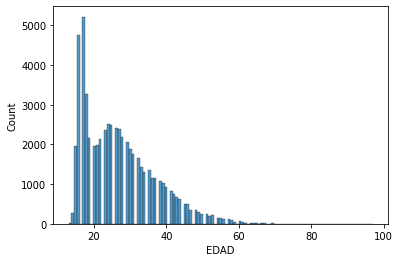

In [ ]:
sns.histplot(data=df, x="EDAD")

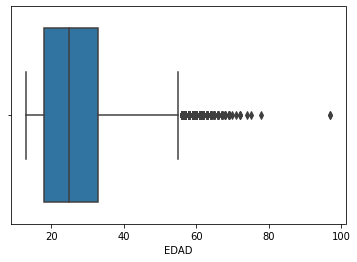

In [ ]:
ax = sns.boxplot(x=df["EDAD"])

Analizando columna género

In [ ]:

select = ['GENERO','ESTUDIANTES']
grupos = ['GENERO']
df_result = df[select].groupby(by=grupos).count()
df_result.reset_index(inplace=True)
df_result.sort_values(ascending=False, by=['ESTUDIANTES'], inplace=True)
df_result

,GENERO,ESTUDIANTES
1,MASCULINO,42975
0,FEMENINO,18584
2,NO REGISTRA,117


Analizando la columna Ruta

In [ ]:

select = ['RUTA','ESTUDIANTES']
grupos = ['RUTA']
df_result = df[select].groupby(by=grupos).count()
df_result.reset_index(inplace=True)
df_result.sort_values(ascending=False, by=['ESTUDIANTES'], inplace=True)
df_result

,RUTA,ESTUDIANTES
1,RUTA 2,48983
0,RUTA 1,12693


Analizando columna Grado

In [ ]:

select = ['GRADO','ESTUDIANTES']
grupos = ['GRADO']
df_result = df[select].groupby(by=grupos).count()
df_result.reset_index(inplace=True)
df_result.sort_values(ascending=False, by=['ESTUDIANTES'], inplace=True)
df_result

,GRADO,ESTUDIANTES
0,-1,48983
3,11,6651
2,10,5490
1,9,552


Se reemplazan los valores -1 por 'Bachiller +'

In [ ]:
df['GRADO'] = df['GRADO'].replace([-1],'Bachiller+')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61676 entries, 80 to 429697
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   DEPARTAME_NOMBRE  61676 non-null  object
 1   ESTRATO_SOCIAL    61676 non-null  object
 2   EDAD              61676 non-null  int64 
 3   GENERO            61676 non-null  object
 4   RUTA              61676 non-null  object
 5   GRADO             61676 non-null  object
 6   ESTADOS           61676 non-null  object
 7   ESTUDIANTES       61676 non-null  int64 
 8   GRADUADO          61676 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 6.7+ MB


# Seleccionando y binarizando entradas para el modelo

In [ ]:
 input = pd.get_dummies(df[['DEPARTAME_NOMBRE',
         'ESTRATO_SOCIAL', 'GENERO', 'RUTA', 'GRADO']], drop_first='false')

In [ ]:
input.head(4)

,DEPARTAME_NOMBRE_ANTIOQUIA,DEPARTAME_NOMBRE_ARAUCA,DEPARTAME_NOMBRE_ATLANTICO,DEPARTAME_NOMBRE_BOGOTA,DEPARTAME_NOMBRE_BOLIVAR,DEPARTAME_NOMBRE_BOYACA,DEPARTAME_NOMBRE_CALDAS,DEPARTAME_NOMBRE_CAQUETA,DEPARTAME_NOMBRE_CASANARE,DEPARTAME_NOMBRE_CAUCA,...,ESTRATO_SOCIAL_3,ESTRATO_SOCIAL_4,ESTRATO_SOCIAL_5,ESTRATO_SOCIAL_6,GENERO_MASCULINO,GENERO_NO REGISTRA,RUTA_RUTA 2,GRADO_10,GRADO_11,GRADO_Bachiller+
80,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
123,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
148,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
149,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
input = input.join(df['EDAD'])


In [ ]:
output = df['GRADUADO']

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# output = df_clientes['Score Cliente'].values.astype('float32');
# input  = df_clientes[['Ind. Préstamo','Ind. Formación']].values.astype('float32');
input_tra, input_val, output_tra, output_val = train_test_split(input, 
                                                                output, test_size=0.3);

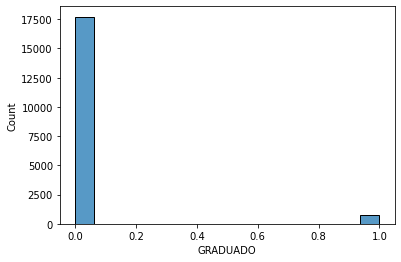

In [ ]:
ax = sns.histplot(x=output_val)

# Regresión logística (por defecto)


In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
log = LogisticRegression();
log_fit = log.fit(input_tra, output_tra)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


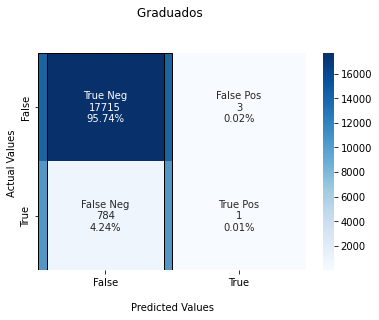

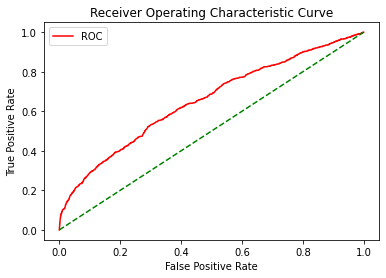

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     17718
           1       0.25      0.00      0.00       785

    accuracy                           0.96     18503
   macro avg       0.60      0.50      0.49     18503
weighted avg       0.93      0.96      0.94     18503



In [ ]:
predicted = log_fit.predict(input_val)
ax = sns.histplot(x=predicted)
show_results(output_val, predicted)


# Redes neuronales (MLPClassifier)

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
mlpc = MLPClassifier(hidden_layer_sizes=(4,4,4,4))
mlpc_fit = mlpc.fit(input_tra, output_tra)


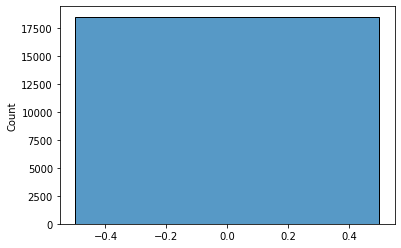

In [ ]:
predicted = mlpc_fit.predict(input_val)
ax = sns.histplot(x=predicted)

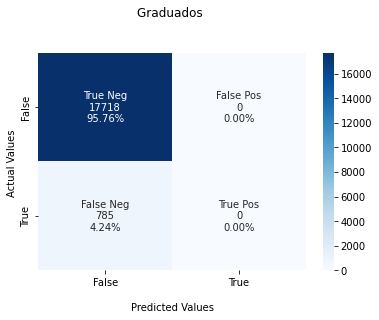

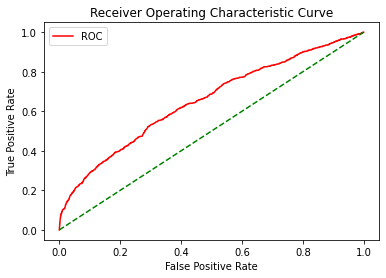

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     17718
           1       0.00      0.00      0.00       785

    accuracy                           0.96     18503
   macro avg       0.48      0.50      0.49     18503
weighted avg       0.92      0.96      0.94     18503



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
show_results(output_val, predicted)

# Intentando penalización L2

In [ ]:
log_fit = LogisticRegression(C=1.0,penalty='l2',random_state=1,solver="newton-cg",class_weight="balanced")
log_fit = log.fit(input_tra, output_tra)
log_fit.score(input_val, output_val)
predicted = log_fit.predict(input_val)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


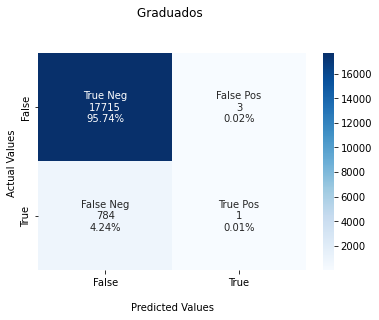

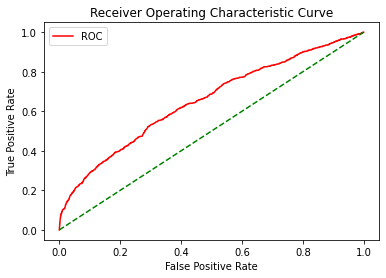

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     17718
           1       0.25      0.00      0.00       785

    accuracy                           0.96     18503
   macro avg       0.60      0.50      0.49     18503
weighted avg       0.93      0.96      0.94     18503



In [ ]:
show_results(output_val, predicted)

# Oversampling de la clase minoritaria

In [ ]:
from imblearn.over_sampling import RandomOverSampler

In [ ]:
os =  RandomOverSampler(sampling_strategy=0.5)
X_train_res, y_train_res = os.fit_resample(input_tra, output_tra)

print ("Distribution before resampling {}".format(Counter(output_tra)))
print ("Distribution after resampling {}".format(Counter(y_train_res)))


log_fit = LogisticRegression()
log_fit = log.fit(X_train_res, y_train_res)
#log_fit.score(input_val, output_val)
predicted = log_fit.predict(input_val)



Distribution before resampling Counter({0: 41301, 1: 1872})
Distribution after resampling Counter({0: 41301, 1: 20650})


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


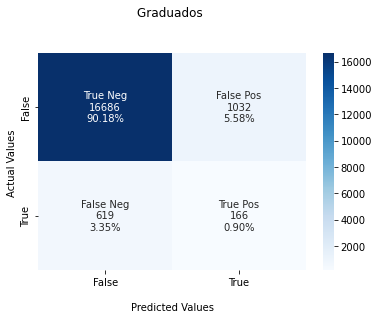

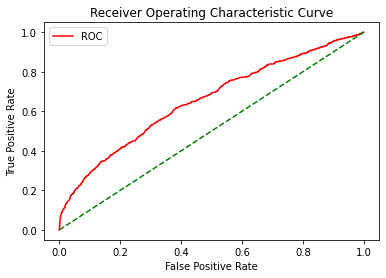

              precision    recall  f1-score   support

           0       0.96      0.94      0.95     17718
           1       0.14      0.21      0.17       785

    accuracy                           0.91     18503
   macro avg       0.55      0.58      0.56     18503
weighted avg       0.93      0.91      0.92     18503



In [ ]:
show_results(output_val, predicted)

# Subsampling en la clase mayoritaria:

In [ ]:
from imblearn.under_sampling import NearMiss

In [ ]:
us = NearMiss(sampling_strategy="auto",  n_neighbors=5, version=2)
X_train_res, y_train_res = us.fit_resample(input_tra, output_tra)

print ("Distribution before resampling {}".format(Counter(output_tra)))
print ("Distribution after resampling {}".format(Counter(y_train_res)))


log_fit = LogisticRegression()
log_fit = log.fit(X_train_res, y_train_res)
predicted = log_fit.predict(input_val)


Distribution before resampling Counter({0: 41301, 1: 1872})
Distribution after resampling Counter({0: 1872, 1: 1872})


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


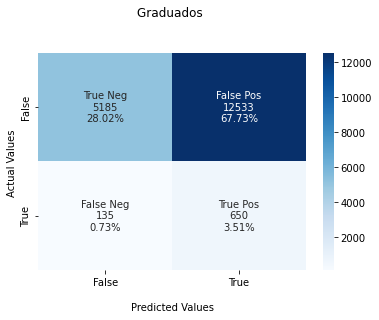

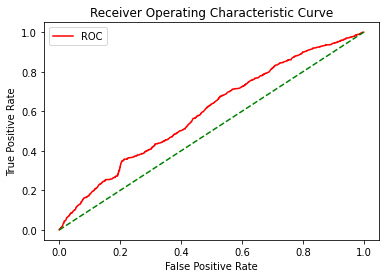

              precision    recall  f1-score   support

           0       0.97      0.29      0.45     17718
           1       0.05      0.83      0.09       785

    accuracy                           0.32     18503
   macro avg       0.51      0.56      0.27     18503
weighted avg       0.94      0.32      0.43     18503



In [ ]:
show_results(output_val, predicted)

# Combinamos resampling con Smoke-Tomek

In [ ]:
os_us = SMOTETomek()
X_train_res, y_train_res = os_us.fit_resample(input_tra, output_tra)

print ("Distribution before resampling {}".format(Counter(output_tra)))
print ("Distribution after resampling {}".format(Counter(y_train_res)))
 

Distribution before resampling Counter({0: 41301, 1: 1872})
Distribution after resampling Counter({0: 41296, 1: 41296})


In [ ]:

log_fit = LogisticRegression()
log_fit = log.fit(X_train_res, y_train_res)
predicted = log_fit.predict(input_val)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


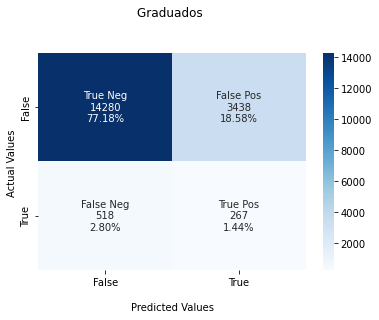

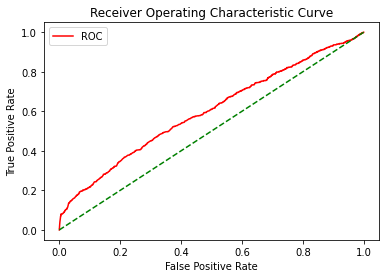

              precision    recall  f1-score   support

           0       0.96      0.81      0.88     17718
           1       0.07      0.34      0.12       785

    accuracy                           0.79     18503
   macro avg       0.52      0.57      0.50     18503
weighted avg       0.93      0.79      0.85     18503



In [ ]:
show_results(output_val, predicted)

# Resumen y Conclusiones

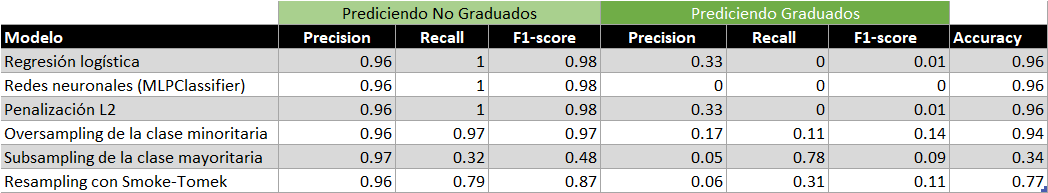



*   Cuando se tratan problemas asociados con clasificación y se cuentan con clases no balanceadas, se requiere explorar diferentes técnicas de muestreo de los datos de entrenamiento.

*   Para encontrar un modelo con mejor desempeño, se podría ensayar estrategias de AutoML.

*   Es probable que estemos frente a un reto que requiera tener mejor selección de las variables de entrada o bien enriquecer el dataset con más características que sean relevantes.



# Recursos

* https://www.aprendemachinelearning.com/clasificacion-con-datos-desbalanceados/


* https://towardsdatascience.com/imbalanced-classification-in-python-smote-tomek-links-method-6e48dfe69bbc

* http://glemaitre.github.io/imbalanced-learn/generated/imblearn.combine.SMOTETomek.html 

* https://machinelearningmastery.com/what-is-imbalanced-classification/

* https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/ **texto en negrita**